# Telsem2AtlasData class implementation
This version also has the beginnings for interpolating angles and frequencies  


stored in ../src/pytelsem.py

___ 
___ 

Try the new class implemented in a separated script

In [14]:
import os
import sys

import geopandas as gp
import xarray as xr
import numpy as np

# from shapely.geometry import box

from scipy.interpolate import griddata

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))
from src.pytelsem import Telsem2AtlasData
from src.processing import windsat_datacube

In [4]:
# Instantiate the class with the path to the atlas file.
path = r"..\..\data\raw\telsem2_mw_atlas\ssmi_mean_emis_climato_01_cov_interpol_M2"
atlas = Telsem2AtlasData(path=path)
# Populate the atlas data
atlas.rttov_readmw_atlas()

0

In [5]:
# OPTIONAL: fill the "atlas.coordinates" attribute
atlas.get_all_coordinates()

In [6]:
# Export the data into a GeoDataFrame
gdf = atlas.to_geopandas()

In [7]:
# Save the object into a geojson file.
filename = os.path.join(
    r"..\\..\\data\processed\GeoTelsem", os.path.basename(atlas.path) + ".geojson"
)
print("Saving file: ", filename)
gdf.to_file(filename, driver="GeoJSON")

Saving file:  ..\\..\\data\processed\GeoTelsem\ssmi_mean_emis_climato_01_cov_interpol_M2.geojson


### Some examples of data manipulation

<Axes: >

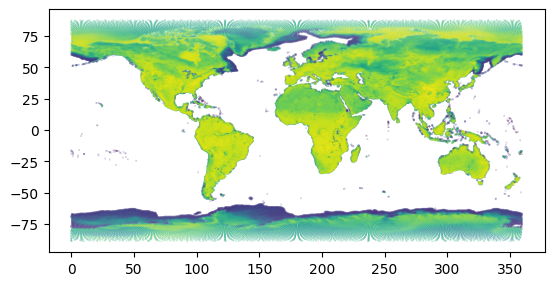

In [8]:
gdf.plot("Emis37H", s=0.01)

In [7]:
# Calculate the full grid with the same formula, not just the available cells
# Longitude points per latitude
ncells_per_lat = atlas.ncells

res_lat = 0.25
lat_band_number = 720

coordinates = []
for i in range(lat_band_number):
    for j in range(atlas.ncells[i]):
        lat = (i - 0.5) * res_lat - 90
        lon = (j - 0.5) * (360 / atlas.ncells[i])

        coordinates.append((lon, lat))

print(len(coordinates))

660066


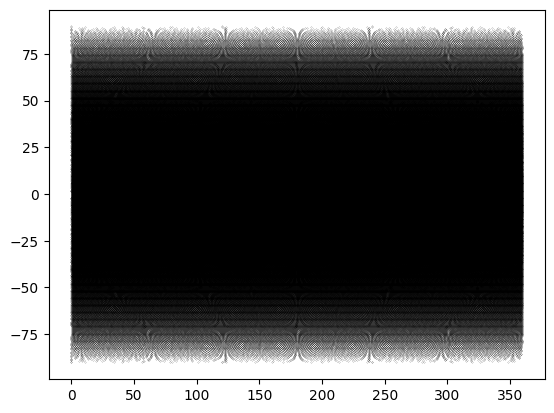

In [8]:
# unravel and check that we have all the coordinates:
import matplotlib.pyplot as plt

lons = [(coord[0] + 180) % 360 for coord in coordinates]
lats = [coord[1] for coord in coordinates]
# Correct the longitudes so GM = 180
plt.scatter(lons, lats, c="black", s=0.01)

---

Iterate over the whole atlas

In [15]:
# Create geo dataframes from the atlas data if they dont exists.
atlas_folder = r"..\\..\\data\\raw\\telsem2_mw_atlas\\"
geodataframe_folder = r"..\\..\\data\\processed\\GeoTelsem\\"

for atlas_name in os.listdir(atlas_folder):

    # Exceptions to the loop
    if not atlas_name.endswith("_cov_interpol_M2"):
        continue

    if atlas_name + ".geojson" in os.listdir(geodataframe_folder):
        print(f"Atlas {atlas_name}.geojson already exists, SKIP")
        continue

    file_path = os.path.join(atlas_folder, atlas_name)
    save_path = os.path.join(geodataframe_folder, atlas_name + ".geojson")

    print(f"Processing atlas {file_path}")
    atlas = Telsem2AtlasData(path=file_path)

    print("Populate the atlas data")
    atlas.rttov_readmw_atlas()

    print("Get coordinates")
    atlas.get_all_coordinates()

    print("Create geopandas object")
    gpd = atlas.to_geopandas()

    print(f"Save into {save_path}")
    gdf.to_file(save_path, driver="GeoJSON")

    print("NEXT")

print("DONE")


Atlas ssmi_mean_emis_climato_01_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_02_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_03_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_04_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_05_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_06_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_07_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_08_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_09_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_10_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_11_cov_interpol_M2.geojson already exists, SKIP
Atlas ssmi_mean_emis_climato_12_cov_interpol_M2.geojson already exists, SKIP
DONE


### Create a gridded version of the data

In [53]:
# load a single file:
import geopandas as gp

filename = (
    r"..\..\data\processed\GeoTelsem\ssmi_mean_emis_climato_01_cov_interpol_M2.geojson"
)
gdf = gp.read_file(filename)

# Set the crs to be geographical 
gdf.set_crs(epsg=4326)
# Transform the coordinates to the epsg: 6933 (EASE Grid v2 25km)
gdf.to_crs(epsg=6933, inplace=True)
gdf

,Emis19V,Emis19H,Emis22V,Emis37V,Emis37H,Emis85V,Emis85H,VarEmis19V,VarEmis19H,VarEmis22V,VarEmis37V,VarEmis37H,VarEmis85V,VarEmis85H,Surface_class1,Surface_class2,geometry
0,0.851150,0.694974,0.852954,0.860778,0.742279,0.821671,0.757044,0.013153,0.011402,0.013528,0.009487,0.014799,0.032249,0.028931,6,21,POINT (-15878884.978 -7340802.126)
1,0.850715,0.694205,0.852940,0.862427,0.742945,0.830328,0.764085,0.013266,0.011533,0.013675,0.009798,0.014629,0.028775,0.027550,6,21,POINT (-14886454.667 -7340802.126)
2,0.848923,0.688440,0.850987,0.862822,0.738313,0.845982,0.776129,0.013748,0.011874,0.014107,0.010630,0.014248,0.022000,0.024145,6,21,POINT (-13894024.356 -7340802.126)
3,0.848579,0.684609,0.849558,0.860756,0.732303,0.853847,0.782463,0.014283,0.012490,0.014663,0.011269,0.014213,0.017029,0.021772,6,21,POINT (-12901594.045 -7340802.126)
4,0.849775,0.683814,0.849110,0.857601,0.727091,0.856796,0.785715,0.014933,0.013638,0.015330,0.011832,0.014765,0.013491,0.020421,6,21,POINT (-11909163.734 -7340802.126)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227138,0.923250,0.853500,0.895250,0.793000,0.741750,0.741500,0.717250,0.023749,0.027495,0.021471,0.023195,0.023388,0.026211,0.020050,7,16,POINT (14418327.162 7335866.559)
227139,0.914857,0.833714,0.883143,0.778571,0.719571,0.728857,0.693571,0.032772,0.043543,0.033615,0.035285,0.041437,0.052612,0.053198,7,16,POINT (15073705.669 7335866.559)
227140,0.919850,0.833513,0.890109,0.780906,0.717361,0.731695,0.693844,0.024920,0.034103,0.025826,0.031780,0.037470,0.048456,0.051010,7,16,POINT (15729084.177 7335866.559)
227141,0.931400,0.842800,0.901800,0.787400,0.722200,0.726600,0.691800,0.012124,0.015297,0.008775,0.019131,0.025159,0.037000,0.045727,7,16,POINT (16384462.684 7335866.559)


In [105]:
# Read a EASEv2 grid values from an existing dataset_
auxiliary_dataset_path = "../../carla\data\processed\EASEv2_AMSRU_Mland_2017001A.tif"
aux_ds = xr.open_dataset(auxiliary_dataset_path)
aux_ds = aux_ds.drop("band_data")
aux_ds = aux_ds.drop_vars("band")
print(aux_ds.sizes)

# Get the x,y coordinates 
x_coords = aux_ds.x.values
y_coords = aux_ds.y.values

grid_x, grid_y = np.meshgrid(x_coords, y_coords)
grid_x.shape, grid_y.shape

xi = (grid_x,grid_y)


Frozen({'x': 1388, 'y': 584})


C:\Users\andre\AppData\Local\Temp\ipykernel_12888\3896173675.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  aux_ds = aux_ds.drop("band_data")


In [106]:
# Select the band and the geometry from the data
band_name = "Emis19H"
gdf_sel = gdf[["geometry",band_name]]

# Get the coordinates of the values
coordinates = gdf_sel.get_coordinates()

# Get the values for the band
band_data = gdf_sel[band_name]

# Call the scipy function to get the gridded data:
arr = griddata(coordinates, band_data, (grid_x,grid_y),method= "linear", fill_value=np.nan)

((227143,), (227143, 2))

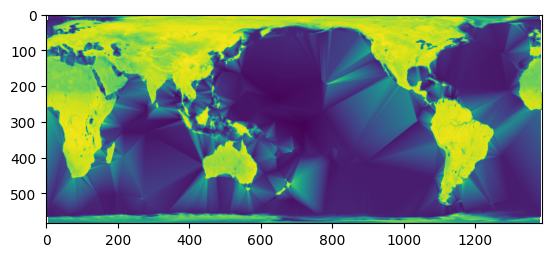

In [84]:
import matplotlib.pyplot as plt
plt.imshow(arr)

In [108]:
aux_ds

<xarray.Dataset> Size: 16kB
Dimensions:      (x: 1388, y: 584)
Coordinates:
  * x            (x) float64 11kB -1.736e+07 -1.733e+07 ... 1.733e+07 1.736e+07
  * y            (y) float64 5kB 7.295e+06 7.27e+06 ... -7.27e+06 -7.295e+06
    spatial_ref  int32 4B ...
Data variables:
    *empty*

<xarray.Dataset> Size: 7MB
Dimensions:      (x: 1388, y: 584)
Coordinates:
  * x            (x) float64 11kB -1.736e+07 -1.733e+07 ... 1.733e+07 1.736e+07
  * y            (y) float64 5kB 7.295e+06 7.27e+06 ... -7.27e+06 -7.295e+06
    spatial_ref  int32 4B ...
Data variables:
    Emis19H      (y, x) float64 6MB nan nan nan nan 0.8211 ... nan nan nan nan

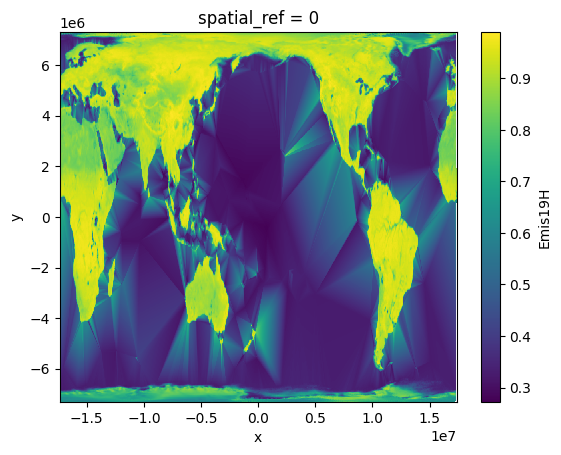

In [109]:
# Create an xarray Dataset with the same coordinates and store the data into a data array
ds = xr.full_like(aux_ds, fill_value=np.nan)

ds[band_name] = xr.DataArray(data=arr, dims=["y","x"])
ds[band_name].plot()
ds

In [115]:
# Do the same for all bands in the dataset:
ds = xr.full_like(aux_ds, fill_value=np.nan)

for band_name in gdf.columns:

    if band_name.endswith("H") or band_name.endswith("V"):
        # Linear interpolation for emissivities and Variances. TODO: ask about interpolating variance. Do we need them at all ? 
        print(f"Linear interpolation for {band_name}")
        gdf_sel = gdf[["geometry",band_name]]

        # Get the coordinates of the values
        coordinates = gdf_sel.get_coordinates()

        # Get the values for the band
        band_data = gdf_sel[band_name]

        # Call the scipy function to get the gridded data:
        arr = griddata(coordinates, band_data, (grid_x,grid_y),method= "linear", fill_value=np.nan)

        # Assign the array to the dataset dvar
        ds[band_name] = xr.DataArray(data=arr, dims=["y","x"])

    else:
        if band_name == "geometry":
            # TODO: add longitude and latitude coordinates to the dataset.
            print("Geometry band skipped for now")

        else:
            # Nearest interpolation, for Surface Classification 
            print(f"NN interpolation for {band_name}")
            gdf_sel = gdf[["geometry",band_name]]

            # Get the coordinates of the values
            coordinates = gdf_sel.get_coordinates()

            # Get the values for the band
            band_data = gdf_sel[band_name]

            # Call the scipy function to get the gridded data:
            arr = griddata(coordinates, band_data, (grid_x,grid_y),method= "linear", fill_value=np.nan)

            # Assign the array to the dataset dvar
            ds[band_name] = xr.DataArray(data=arr, dims=["y","x"])



Linear interpolation for Emis19V
Linear interpolation for Emis19H
Linear interpolation for Emis22V
Linear interpolation for Emis37V
Linear interpolation for Emis37H
Linear interpolation for Emis85V
Linear interpolation for Emis85H
Linear interpolation for VarEmis19V
Linear interpolation for VarEmis19H
Linear interpolation for VarEmis22V
Linear interpolation for VarEmis37V
Linear interpolation for VarEmis37H
Linear interpolation for VarEmis85V
Linear interpolation for VarEmis85H
NN interpolation for Surface_class1
NN interpolation for Surface_class2
Geomtry band skipped for now


In [116]:
ds

<xarray.Dataset> Size: 104MB
Dimensions:         (x: 1388, y: 584)
Coordinates:
  * x               (x) float64 11kB -1.736e+07 -1.733e+07 ... 1.736e+07
  * y               (y) float64 5kB 7.295e+06 7.27e+06 ... -7.27e+06 -7.295e+06
    spatial_ref     int32 4B ...
Data variables: (12/16)
    Emis19V         (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    Emis19H         (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    Emis22V         (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    Emis37V         (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    Emis37H         (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    Emis85V         (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    ...              ...
    VarEmis37V      (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    VarEmis37H      (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    VarEmis85V      (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    VarEmis85H      (y, x) float64 6MB nan nan nan nan ... nan nan nan nan
    Surface_class1  (y, x) float64 6MB nan nan nan nan 7.019 ... nan nan nan nan
    Surface_class2  (y, x) float64 6MB nan nan nan nan 15.97 ... nan nan nan nan

In [123]:
# Save the dataset
save_path = os.path.join(geodataframe_folder, "ssmi_mean_emis_climato_01_cov_interpol_M2.h5")

ds.to_netcdf(save_path)

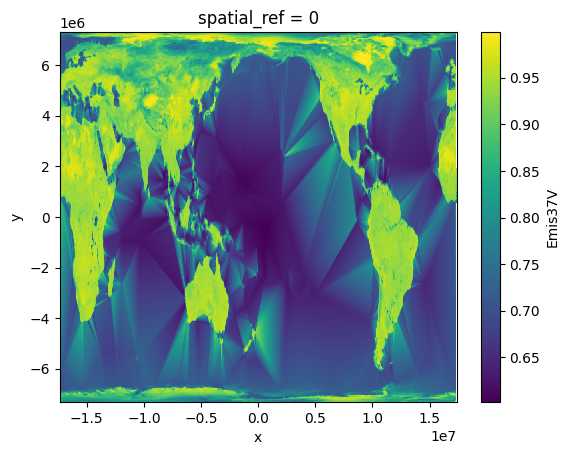

In [125]:
# Exploration:
ds.Emis37V.plot(cmap="viridis")

---

Full loop, instead of saving the geojson, save the gridded data

In [130]:
print(file_path)
print(os.path.basename(file_path))
print(os.path.dirname(file_path))

atlas_name = os.path.basename(file_path)
atlas_folder = os.path.dirname(file_path)

..\\..\\data\\raw\\telsem2_mw_atlas\\ssmi_mean_emis_climato_12_cov_interpol_M2
ssmi_mean_emis_climato_12_cov_interpol_M2
..\\..\\data\\raw\\telsem2_mw_atlas


In [15]:
# Function definition for convenience:


def telsem2geodf(file_path: str) -> gp.GeoDataFrame:
    """ 
    Read the atlas data for a single file and return the geodataframe with the data.
    """

    print(f"Processing atlas {file_path}")
    atlas = Telsem2AtlasData(path=file_path)

    print("Populate the atlas data")
    atlas.rttov_readmw_atlas()

    print("Get coordinates")
    atlas.get_all_coordinates()

    gdf = atlas.to_geopandas()
    # Set the crs to be geographical 
    gdf.set_crs(epsg=4326)
    
    # # Transform the coordinates to the epsg: 6933 (EASE Grid v2 25km)
    # gdf.to_crs(epsg=6933, inplace=True)

    return gdf

def create_auxds(auxiliary_dataset_path: str) -> xr.Dataset:
    """
        Create a baseline dataset for the gridding to fill
    """
    aux_ds = xr.open_dataset(auxiliary_dataset_path)
    aux_ds = aux_ds.drop_vars("band_data")
    aux_ds = aux_ds.drop_vars("band")

    return aux_ds


def geodf2xarray(gdf: gp.GeoDataFrame, aux_ds: xr.Dataset) -> xr.Dataset:
    """ 
    Grid the Gdataframe into EASE v2 25km, using an existing dataset as a baseline
    """

    # Get the x,y coordinates form the auxiliary dataset in EASEv2 25km
    x_coords = aux_ds.lon.values
    y_coords = aux_ds.lat.values

    grid_x, grid_y = np.meshgrid(x_coords, y_coords)

    # Create an empty dataset like the auxiliary one, with x,y coordinates and the spacial reference
    ds = xr.full_like(aux_ds, fill_value=np.nan)

    for band_name in gdf.columns:

        if band_name.endswith("H") or band_name.endswith("V"):
            # Linear interpolation for emissivities and Variances. TODO: ask about interpolating variance. Do we need them at all ? 
            print(f"Linear interpolation for {band_name}")

            # Select the common data between geometry and the band
            gdf_sel = gdf[["geometry",band_name]]

            # Get the values that we have for this band, along with their coordinates.
            coordinates = gdf_sel.get_coordinates()
            band_data = gdf_sel[band_name]

            # Call the scipy function to get the gridded data:
            arr = griddata(coordinates, band_data, (grid_x,grid_y),method= "linear", fill_value=np.nan)

            # Assign the array to the dataset dvar
            ds[band_name] = xr.DataArray(data=arr, dims=["latitude_grid","longitude_grid"])

        else:
            if band_name == "geometry":
                # TODO: add longitude and latitude coordinates to the dataset.
                print("Geometry band skipped for now")

            else:
                # Nearest interpolation, for Surface Classification 
                print(f"NN interpolation for {band_name}")
                gdf_sel = gdf[["geometry",band_name]]

                # Get the values that we have for this band, along with their coordinates.
                coordinates = gdf_sel.get_coordinates()
                band_data = gdf_sel[band_name]

                # Call the scipy function to get the gridded data:
                arr = griddata(coordinates, band_data, (grid_x,grid_y),method= "linear", fill_value=np.nan)

                # Assign the array to the dataset dvar
                ds[band_name] = xr.DataArray(data=arr, dims=["latitude_grid","longitude_grid"])

    return ds

In [16]:
auxiliary_dataset_path = r"..\..\data\raw\Daily_Windsat"
aux_ds = windsat_datacube(auxiliary_dataset_path)
aux_ds = aux_ds.drop_vars([dv for dv in aux_ds.data_vars])
aux_ds = aux_ds.drop_vars("day_number")
aux_ds

<xarray.Dataset> Size: 9kB
Dimensions:  (latitude_grid: 720, longitude_grid: 1440)
Coordinates:
    lat      (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon      (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
Dimensions without coordinates: latitude_grid, longitude_grid
Data variables:
    *empty*
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [17]:
# FINAL LOOP: ~3.5 min to complete 1 atlas file. 
""" 
Read all the atlas files
for file in folder:
    - read the atlas
    - convert the atlas file into a geodataframe
    - Grid the geodataframe using an xarray dataset
    - Save the dataset in netcdf
"""

# Create .ch files from the atlas data if they dont exists.
atlas_folder = "..\\..\\data\\raw\\telsem2_mw_atlas\\"
datasets_folder = "..\\..\\data\processed\WinsatEmiss"

# Read a EASEv2 grid values from an existing dataset_
# auxiliary_dataset_path = "..\..\data\raw\Daily_Windsat"
# aux_ds = windsat_datacube(auxiliary_dataset_path)

for atlas_name in os.listdir(atlas_folder):

    # Exceptions to the loop
    if not atlas_name.endswith("_cov_interpol_M2"):
        continue

    if atlas_name + ".nc" in os.listdir(datasets_folder):
        print(f"Atlas {atlas_name}.nc already exists.")
        continue

    file_path = os.path.join(atlas_folder, atlas_name)
    save_path = os.path.join(datasets_folder, atlas_name + ".nc")

    # Grid the data with the functions
    gdf = telsem2geodf(file_path)
    ds = geodf2xarray(gdf,aux_ds)

    # Save the datasets
    print(f"Saved in {save_path}")
    ds.to_netcdf(save_path)

    print("NEXT")

print("DONE")


Processing atlas ..\..\data\raw\telsem2_mw_atlas\ssmi_mean_emis_climato_01_cov_interpol_M2
Populate the atlas data
Get coordinates
Geometry band skipped for now
Linear interpolation for Emis19V
Linear interpolation for Emis19H
Linear interpolation for Emis22V
Linear interpolation for Emis37V
Linear interpolation for Emis37H
Linear interpolation for Emis85V
Linear interpolation for Emis85H
Linear interpolation for VarEmis19V
Linear interpolation for VarEmis19H
Linear interpolation for VarEmis22V
Linear interpolation for VarEmis37V
Linear interpolation for VarEmis37H
Linear interpolation for VarEmis85V
Linear interpolation for VarEmis85H
NN interpolation for Surface_class1
NN interpolation for Surface_class2
Saved in ..\..\data\processed\WinsatEmiss\ssmi_mean_emis_climato_01_cov_interpol_M2.nc
NEXT
Processing atlas ..\..\data\raw\telsem2_mw_atlas\ssmi_mean_emis_climato_02_cov_interpol_M2
Populate the atlas data
Get coordinates
Geometry band skipped for now
Linear interpolation for Emis19

In [20]:
# open the datasets with dask
telsem_ds = xr.open_mfdataset(
    paths = "../../data/processed/WinsatEmiss/*.nc",
    engine="netcdf4",
    concat_dim="month",
    combine="nested"
)
telsem_ds

<xarray.Dataset> Size: 2GB
Dimensions:         (latitude_grid: 720, longitude_grid: 1440, month: 12)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
Dimensions without coordinates: latitude_grid, longitude_grid, month
Data variables: (12/16)
    Emis19V         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis19H         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis22V         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37V         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis37H         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Emis85V         (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    VarEmis37V      (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    VarEmis37H      (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    VarEmis85V      (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    VarEmis85H      (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Surface_class1  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    Surface_class2  (month, latitude_grid, longitude_grid) float64 100MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [28]:
# Add the longitude and latitude of the grid instead of the projected coordinates xy
# Load a windsat dataset and recover the lat and lon values.
from src.processing import windsat_datacube
folder_path = "../../data/raw/Daily_Windsat/"
wsds = windsat_datacube(folder_path)
lat = wsds.lat
lon = wsds.lon


In [29]:
wsds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

---

Some more experimentation 

In [9]:

filename = (
    r"..\data\processed\GeoTelsem\ssmi_mean_emis_climato_01_cov_interpol_M2.geojson"
)
gdf = gp.read_file(filename)

In [10]:
gdf

,Emis19V,Emis19H,Emis22V,Emis37V,Emis37H,Emis85V,Emis85H,VarEmis19V,VarEmis19H,VarEmis22V,VarEmis37V,VarEmis37H,VarEmis85V,VarEmis85H,Surface_class1,Surface_class2,geometry
0,0.851150,0.694974,0.852954,0.860778,0.742279,0.821671,0.757044,0.013153,0.011402,0.013528,0.009487,0.014799,0.032249,0.028931,6,21,POINT (195.42857 -88.87500)
1,0.850715,0.694205,0.852940,0.862427,0.742945,0.830328,0.764085,0.013266,0.011533,0.013675,0.009798,0.014629,0.028775,0.027550,6,21,POINT (205.71429 -88.87500)
2,0.848923,0.688440,0.850987,0.862822,0.738313,0.845982,0.776129,0.013748,0.011874,0.014107,0.010630,0.014248,0.022000,0.024145,6,21,POINT (216.00000 -88.87500)
3,0.848579,0.684609,0.849558,0.860756,0.732303,0.853847,0.782463,0.014283,0.012490,0.014663,0.011269,0.014213,0.017029,0.021772,6,21,POINT (226.28571 -88.87500)
4,0.849775,0.683814,0.849110,0.857601,0.727091,0.856796,0.785715,0.014933,0.013638,0.015330,0.011832,0.014765,0.013491,0.020421,6,21,POINT (236.57143 -88.87500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227138,0.923250,0.853500,0.895250,0.793000,0.741750,0.741500,0.717250,0.023749,0.027495,0.021471,0.023195,0.023388,0.026211,0.020050,7,16,POINT (149.43396 87.62500)
227139,0.914857,0.833714,0.883143,0.778571,0.719571,0.728857,0.693571,0.032772,0.043543,0.033615,0.035285,0.041437,0.052612,0.053198,7,16,POINT (156.22642 87.62500)
227140,0.919850,0.833513,0.890109,0.780906,0.717361,0.731695,0.693844,0.024920,0.034103,0.025826,0.031780,0.037470,0.048456,0.051010,7,16,POINT (163.01887 87.62500)
227141,0.931400,0.842800,0.901800,0.787400,0.722200,0.726600,0.691800,0.012124,0.015297,0.008775,0.019131,0.025159,0.037000,0.045727,7,16,POINT (169.81132 87.62500)


In [2]:
# Geopandas inbluilt finction
projection = "EPSG:4326"
reprojected_gdf = gdf.to_crs(projection)

# Create the array:
grid_size = 0.1

# Grid boundaries based on the extent of the reprojected GeoDataFrame
min_x, min_y, max_x, max_y = reprojected_gdf.total_bounds
x_bins = np.arange(min_x, max_x + grid_size, grid_size)
y_bins = np.arange(min_y, max_y + grid_size, grid_size)

# Initialize an empty array to hold aggregated values
array_shape = (len(y_bins), len(x_bins))  # shape of the array
array = np.zeros(array_shape)
print(array.shape)

(1766, 3601)


In [ ]:
# Aggregate points into grid cells
for index, row in reprojected_gdf.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    # Find the indices of the grid cell where the point falls
    x_index = np.searchsorted(x_bins, x, side="right") - 1
    y_index = np.searchsorted(y_bins, y, side="right") - 1
    # Increment the corresponding array element
    array[y_index, x_index] = row["Emis37H"]

In [5]:
# TODO: Bilinear interpolation to create the projected array

import geopandas as gpd
import numpy as np

# Choose the EPSG code for the Equirectangular projection
target_crs = "EPSG:4326"

# Project the GeoDataFrame to the Equirectangular projection
reprojected_gdf = gdf.to_crs(target_crs)

# Define the desired shape of the array
desired_shape = (720, 1440)

# Calculate the extent of the reprojected GeoDataFrame
min_x, min_y, max_x, max_y = reprojected_gdf.total_bounds

# Calculate the width and height of each pixel in the array
pixel_width = (max_x - min_x) / desired_shape[1]
pixel_height = (max_y - min_y) / desired_shape[0]

# Create a meshgrid of x and y coordinates
x_coords = np.linspace(
    min_x + pixel_width / 2, max_x - pixel_width / 2, desired_shape[1]
)
y_coords = np.linspace(
    min_y + pixel_height / 2, max_y - pixel_height / 2, desired_shape[0]
)
xx, yy = np.meshgrid(x_coords, y_coords)

# Now you have a meshgrid of coordinates in the Equirectangular projection
# You can use these coordinates to sample the values from your GeoDataFrame or perform other operations

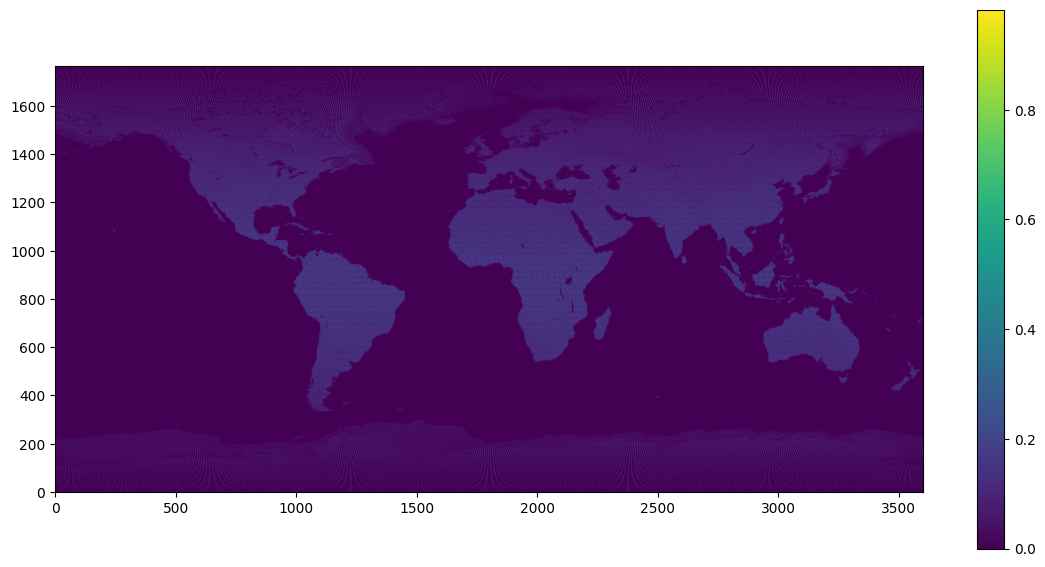

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.imshow(array, origin="lower")
plt.colorbar()

## Interpolation port to python (DEPRECATED METHOD)

In [53]:
# # Helper functions:
# def calc_cellnum_mult(lat, lon, resol, atlas):
#     # Function to compute cell numbers given the latitude, longitude, and resolution
#     cell_num_mult = []
#     nb_cell = 0

#     # Calculate the cellnum in the older file
#     ilat = min(int((lat + 90.0) / atlas.dlat) + 1, len(atlas.ncells))
#     ilon = int(lon / (360.0 / atlas.ncells[ilat - 1])) + 1
#     calc_cellnum = sum(atlas.ncells[: ilat - 1]) + ilon

#     # Search for the nbcel pixels that are in the box of resolution 'resol' around lat and lon
#     maxlat = 180.0 / atlas.dlat
#     nbcel = 1
#     cell = [calc_cellnum]
#     nbreslat = int(resol / atlas.dlat / 2.0)

#     if nbreslat >= 1:
#         for i2lat in range(ilat - nbreslat, ilat + nbreslat + 1):
#             if 1 <= i2lat <= int(maxlat):
#                 if abs((i2lat - 0.5) * atlas.dlat - 90 - lat) <= resol / 2.0:
#                     i2lon = int(lon / (360.0 / atlas.ncells[i2lat - 1])) + 1
#                     nbreslon = int(
#                         resol / (360.0 / (1.0 * atlas.ncells[i2lat - 1])) / 2.0
#                     )

#                     for i3lon in range(i2lon - nbreslon, i2lon + nbreslon + 1):
#                         if (
#                             np.mod(
#                                 np.abs(
#                                     (i3lon - 0.5) * (360.0 / atlas.ncells[i2lat - 1])
#                                     - lon
#                                 ),
#                                 360.0,
#                             )
#                             <= resol / 2.0
#                         ):
#                             nbcel += 1
#                             i4lon = i3lon
#                             if i3lon < 1:
#                                 i4lon = atlas.ncells[i2lat - 1] + i3lon
#                             if i3lon >= atlas.ncells[i2lat - 1]:
#                                 i4lon = i3lon - atlas.ncells[i2lat - 1]
#                             new_cell = atlas.firstcell[i2lat - 1] + i4lon - 1
#                             if new_cell != cell[0]:
#                                 cell.append(new_cell)

#     nb_cell = nbcel
#     cell_num_mult = np.array(cell, dtype=int)

#     return cell_num_mult, nb_cell


# def interp_freq2(emiss19, emiss37, emiss85, f, class2):
#     # Linear interpolation of emissivity up to 85 GHz
#     # Frequency interpolation above 85 GHz only for classes 10 to 13 (water-like classes)
#     rapport43_32 = [0.62, 0.37, 0.46, 0.63]
#     rapport54_43 = [0.30, 0.60, 0.47, 0.35]

#     if f <= 19.35:
#         a = 1
#         b = 0
#         c = 0
#         emiss = emiss19
#     elif f <= 37:
#         a = (37 - f) / (37 - 19.35)
#         b = (f - 19.35) / (37 - 19.35)
#         c = 0
#         emiss = a * emiss19 + b * emiss37
#     elif f < 85.5:
#         a = 0
#         b = (85.5 - f) / (85.5 - 37)
#         c = (f - 37) / (85.5 - 37)
#         emiss = b * emiss37 + c * emiss85
#     else:
#         a = 0
#         b = 0
#         c = 1
#         emiss = emiss85
#         if 9 < class2 < 14 and emiss85 > emiss37:
#             if f <= 150:
#                 emiss = (
#                     emiss85
#                     + (f - 85.5)
#                     * ((emiss85 - emiss37) / (85.5 - 37))
#                     * rapport43_32[class2 - 10]
#                 )
#             elif f <= 190:
#                 emiss = (
#                     emiss85
#                     + (150 - 85.5)
#                     * ((emiss85 - emiss37) / (85.5 - 37))
#                     * rapport43_32[class2 - 10]
#                 )
#                 emiss += (
#                     (f - 150)
#                     * ((emiss - emiss85) / (150 - 85.5))
#                     * rapport54_43[class2 - 10]
#                 )
#             else:
#                 emiss = (
#                     emiss85
#                     + (150 - 85.5)
#                     * ((emiss85 - emiss37) / (85.5 - 37))
#                     * rapport43_32[class2 - 10]
#                 )
#                 emiss += (
#                     (190 - 150)
#                     * ((emiss - emiss85) / (150 - 85.5))
#                     * rapport54_43[class2 - 10]
#                 )
#             if emiss > 1:
#                 emiss = 1

#     return emiss, a, b, c


# def data_string_to_array(data_string: str) -> np.array:
#     """Reads the fortran string representation of the data and returns a numpy array"""
#     _, data, _ = data_string.split("/")

#     lines = data.replace("\n", "").split("&")
#     lines = [l.strip() for l in lines if l.strip()]

#     raw_array = []
#     for line in lines:
#         data_values = line.split(",")
#         data_values = [
#             float(value.split("_")[0]) for value in data_values if value.strip()
#         ]
#         raw_array.append(data_values)

#     return np.array(raw_array)


# def emis_interp(theta, freq, class1, class2, ev, eh):
#     # Coefficients
#     a0_k0 = data_string_to_array(
#         """ 
#         data a0_k0/0.11509_jprb,0.091535_jprb,0.34796_jprb,0.10525_jprb,0.16627_jprb,0.24434_jprb, &
#          & 0.29217_jprb,0.23809_jprb,0.28954_jprb,0.17516_jprb,0.19459_jprb,0.28697_jprb, &
#          & 0.10521_jprb,0.12126_jprb,0.30278_jprb,0.18212_jprb,0.19625_jprb,0.14551_jprb, &
#          & -0.19202_jprb,0.5411_jprb,0.03739_jprb,0.10292_jprb,0.5486_jprb,-0.058937_jprb, &
#          & -0.022672_jprb,0.44492_jprb,-0.058448_jprb,-0.33894_jprb,-0.17621_jprb,0.14742_jprb/
#         """
#     )
#     a0_k1 = data_string_to_array(
#         """
#         data a0_k1/0.61168_jprb,0.59095_jprb,0.7918_jprb,0.60271_jprb,0.69213_jprb,0.62218_jprb, &
#          &  0.32728_jprb,0.34334_jprb,0.37062_jprb,0.51217_jprb,0.4491_jprb,0.50101_jprb, &
#          & 0.48913_jprb,0.41932_jprb,0.29734_jprb,0.64474_jprb,0.30637_jprb,0.031107_jprb, &
#          & 1.0405_jprb,0.17538_jprb,1.3215_jprb,0.61819_jprb,0.31298_jprb,1.7218_jprb, &
#          & 0.87761_jprb,0.47583_jprb,1.2583_jprb,1.0959_jprb,0.92842_jprb,0.51033_jprb/
#         """
#     )
#     a0_k2 = data_string_to_array(
#         """ 
#         data a0_k2/0.26726_jprb,0.32033_jprb,-0.14778_jprb,0.28547_jprb,0.13592_jprb,0.13193_jprb, &
#          & 0.37178_jprb,0.41813_jprb,0.33875_jprb,0.30203_jprb,0.35479_jprb,0.20189_jprb, &
#          & 0.40663_jprb,0.47493_jprb,0.40668_jprb,0.14811_jprb,0.52382_jprb,0.86634_jprb, &
#          & 0.14286_jprb,0.27164_jprb,-0.37947_jprb,0.2737_jprb,0.12001_jprb,-0.67315_jprb, &
#          & 0.13492_jprb,0.065463_jprb,-0.19316_jprb,0.24905_jprb,0.25475_jprb,0.34637_jprb/
    
#         """
#     )
#     a0_eveh = data_string_to_array(
#         """ 
#         data a0_eveh/0.9592599869E+00_jprb,0.9565299749E+00_jprb,0.9511899948E+00_jprb, &
#          & 0.9560700059E+00_jprb,0.9541199803E+00_jprb,0.9483199716E+00_jprb, &
#          & 0.9461100101E+00_jprb,0.9439799786E+00_jprb,0.9387800097E+00_jprb, &
#          & 0.9317600131E+00_jprb,0.9289000034E+00_jprb,0.9236800075E+00_jprb, &
#          & 0.9208700061E+00_jprb,0.9190599918E+00_jprb,0.9105200171E+00_jprb, &
#          & 0.9162799716E+00_jprb,0.8937299848E+00_jprb,0.8014699817E+00_jprb, &
#          & 0.9570500255E+00_jprb,0.9213600159E+00_jprb,0.7893999815E+00_jprb, &
#          & 0.9639400244E+00_jprb,0.9530599713E+00_jprb,0.8850200176E+00_jprb, &
#          & 0.9685299993E+00_jprb,0.9622600079E+00_jprb,0.9118800163E+00_jprb, &
#          & 0.8997200131E+00_jprb,0.9012699723E+00_jprb,0.9107499719E+00_jprb/
    
#         """
#     )
#     a1_eveh = data_string_to_array(
#         """ 
#         data a1_eveh/0.3627802414E-07_jprb,-0.7778328204E-08_jprb,0.4396108011E-07_jprb, &
#          & 0.2503205394E-06_jprb,0.1996262995E-06_jprb,0.2929977541E-06_jprb, &
#          & 0.4190530660E-06_jprb,0.3655744649E-06_jprb,0.3519195673E-06_jprb, &
#          & 0.5574374313E-06_jprb,0.5273076340E-06_jprb,0.5376484182E-06_jprb, &
#          & 0.1026844529E-05_jprb,0.9679998811E-06_jprb,0.8616486866E-06_jprb, &
#          & 0.3180800832E-06_jprb,0.2886778532E-06_jprb,0.2310362675E-06_jprb, &
#          & -0.1118036366E-06_jprb,-0.1502856577E-06_jprb,0.4842232926E-07_jprb, &
#          & -0.8410978580E-08_jprb,-0.3478669441E-07_jprb,0.2209441590E-06_jprb, &
#          & 0.2485776633E-06_jprb,0.1800235907E-06_jprb,0.2510202251E-06_jprb, &
#          & 0.2687000915E-06_jprb,0.1740325644E-06_jprb,0.3562134339E-06_jprb/
#         """
#     )
#     a2_eveh = data_string_to_array(
#         """
#         data a2_eveh/0.3067140824E-05_jprb,0.2520012231E-05_jprb,0.4831396382E-05_jprb, &
#          & 0.8213598448E-05_jprb,0.7378375358E-05_jprb,0.1022081960E-04_jprb, &
#          & 0.1225889173E-04_jprb,0.1165553113E-04_jprb,0.1188659007E-04_jprb, &
#          & 0.1693615741E-04_jprb,0.1648317448E-04_jprb,0.1715818144E-04_jprb, &
#          & 0.2744720041E-04_jprb,0.2642072104E-04_jprb,0.2671847506E-04_jprb, &
#          & 0.1349592094E-04_jprb,0.1261523357E-04_jprb,0.5447756394E-05_jprb, &
#          & 0.2064244654E-05_jprb,0.1919016057E-06_jprb,0.5940860319E-06_jprb, &
#          & 0.5334760772E-05_jprb,0.4130339221E-05_jprb,0.4104662821E-05_jprb, &
#          & 0.6530796327E-05_jprb,0.5727014013E-05_jprb,0.7451782039E-05_jprb, &
#          & 0.1071246970E-04_jprb,0.9539280654E-05_jprb,0.1034286015E-04_jprb/
#         """
#     )
#     a3_eveh = data_string_to_array(
#         """ 
#         data a3_eveh/-0.2004991551E-07_jprb,-0.6895366056E-07_jprb, -0.2047409282E-06_jprb, &
#          & -0.7322448425E-07_jprb,-0.1273002681E-06_jprb,-0.2729916844E-06_jprb, &
#          & -0.9421125213E-07_jprb,-0.1683332300E-06_jprb,-0.2726891637E-06_jprb, &
#          & -0.1317753799E-06_jprb,-0.2107972250E-06_jprb,-0.3556060904E-06_jprb, &
#          & -0.1889465580E-06_jprb,-0.2757958271E-06_jprb,-0.4909850304E-06_jprb, &
#          & 0.7339644004E-08_jprb,-0.4058669560E-06_jprb,-0.4146343997E-06_jprb, &
#          & 0.6170279931E-07_jprb,-0.1998567996E-06_jprb,-0.4713119139E-07_jprb, &
#          & -0.1361754887E-07_jprb,-0.1765622955E-06_jprb,-0.2348146637E-06_jprb, &
#          & -0.3901189061E-07_jprb,-0.1305666189E-06_jprb,-0.1533838798E-06_jprb, &
#          & -0.2679148992E-07_jprb,-0.4441960044E-07_jprb,-0.1815613899E-06_jprb/
#         """
#     )
#     b0_eveh = data_string_to_array(
#         """ 
#         data b0_eveh/0.9592599869E+00_jprb,0.9565299749E+00_jprb,0.9511899948E+00_jprb, &
#          & 0.9560700059E+00_jprb,0.9541199803E+00_jprb,0.9483199716E+00_jprb, &
#          & 0.9461100101E+00_jprb,0.9439799786E+00_jprb,0.9387800097E+00_jprb, &
#          & 0.9317600131E+00_jprb,0.9289000034E+00_jprb,0.9236800075E+00_jprb, &
#          & 0.9208700061E+00_jprb,0.9190599918E+00_jprb,0.9105200171E+00_jprb, &
#          & 0.9162799716E+00_jprb,0.8937299848E+00_jprb,0.8014699817E+00_jprb, &
#          & 0.9570500255E+00_jprb,0.9213600159E+00_jprb,0.7893999815E+00_jprb, &
#          & 0.9639400244E+00_jprb,0.9530599713E+00_jprb,0.8850200176E+00_jprb, &
#          & 0.9685299993E+00_jprb,0.9622600079E+00_jprb,0.9118800163E+00_jprb, &
#          & 0.8997200131E+00_jprb,0.9012699723E+00_jprb,0.9107499719E+00_jprb/
#         """
#     )
#     b1_eveh = data_string_to_array(
#         """ 
#         data b1_eveh/0.3626608347E-07_jprb,-0.7786279177E-08_jprb,0.4393379172E-07_jprb, &
#          & 0.2502746099E-06_jprb,0.1995944388E-06_jprb,0.2929554341E-06_jprb, &
#          & 0.4189516289E-06_jprb,0.3655020180E-06_jprb,0.3518483140E-06_jprb, &
#          & 0.5572838404E-06_jprb,0.5271903092E-06_jprb,0.5375342766E-06_jprb, &
#          & 0.1026605219E-05_jprb,0.9677979733E-06_jprb,0.8614680951E-06_jprb, &
#          & 0.3179358714E-06_jprb,0.2884899004E-06_jprb,0.2308632219E-06_jprb, &
#          & -0.1118781370E-06_jprb,-0.1503948681E-06_jprb,0.4834672396E-07_jprb, &
#          & -0.8455684153E-08_jprb,-0.3485171618E-07_jprb,0.2208606134E-06_jprb, &
#          & 0.2485595019E-06_jprb,0.1799959364E-06_jprb,0.2509846695E-06_jprb, &
#          & 0.2686167306E-06_jprb,0.1739760478E-06_jprb,0.3561317214E-06_jprb/
#         """
#     )
#     b2_eveh = data_string_to_array(
#         """ 
#         data b2_eveh/0.3065537157E-05_jprb,0.2518960400E-05_jprb,0.4829731552E-05_jprb, &
#          & 0.8209894986E-05_jprb,0.7375769655E-05_jprb,0.1021809931E-04_jprb, &
#          & 0.1225203869E-04_jprb,0.1165053800E-04_jprb,0.1188218721E-04_jprb, &
#          & 0.1692612022E-04_jprb,0.1647546378E-04_jprb,0.1715117833E-04_jprb, &
#          & 0.2743142431E-04_jprb,0.2640772436E-04_jprb,0.2670711910E-04_jprb, &
#          & 0.1348545720E-04_jprb,0.1260529825E-04_jprb,0.5439695997E-05_jprb, &
#          & 0.2058213340E-05_jprb,0.1860650656E-06_jprb,0.5898303925E-06_jprb, &
#          & 0.5330772183E-05_jprb,0.4126528893E-05_jprb,0.4100859314E-05_jprb, &
#          & 0.6528573977E-05_jprb,0.5725009032E-05_jprb,0.7449450095E-05_jprb, &
#          & 0.1070590315E-04_jprb,0.9534271157E-05_jprb,0.1033751869E-04_jprb/
#         """
#     )
#     b3_eveh = data_string_to_array(
#         """ 
#         data b3_eveh/-0.1370247134E-06_jprb,-0.1436897747E-06_jprb, -0.2954870411E-06_jprb, &
#          & -0.3118435643E-06_jprb,-0.2916583242E-06_jprb,-0.4311032171E-06_jprb, &
#          & -0.5048401022E-06_jprb,-0.4662823869E-06_jprb,-0.5206445053E-06_jprb, &
#          & -0.7210980471E-06_jprb,-0.6662896794E-06_jprb,-0.7548637200E-06_jprb, &
#          & -0.1110204039E-05_jprb,-0.1030801400E-05_jprb,-0.1140921199E-05_jprb, &
#          & -0.6330818110E-06_jprb,-0.9186441048E-06_jprb,-0.7947813856E-06_jprb, &
#          & -0.3242539890E-06_jprb,-0.5027602583E-06_jprb,-0.2777987334E-06_jprb, &
#          & -0.2747250676E-06_jprb,-0.3811997260E-06_jprb,-0.4102405455E-06_jprb, &
#          & -0.1994112324E-06_jprb,-0.2555484855E-06_jprb,-0.2842682534E-06_jprb, &
#          & -0.4413041665E-06_jprb,-0.3717419474E-06_jprb,-0.4975536854E-06_jprb/
#         """
#     )

#     # Interpolation in angle
#     emiss_scal_v = np.zeros(3)
#     emiss_scal_h = np.zeros(3)
#     for j in range(3):
#         e0 = a0_k0[j, class1] + a0_k1[j, class1] * ev[j] + a0_k2[j, class1] * eh[j]
#         a0 = a0_eveh[j, class1]
#         a1 = a1_eveh[j, class1]
#         a2 = a2_eveh[j, class1]
#         a3 = a3_eveh[j, class1]
#         b0 = b0_eveh[j, class1]
#         b1 = b1_eveh[j, class1]
#         b2 = b2_eveh[j, class1]
#         b3 = b3_eveh[j, class1]
#         theta0 = 0.0
#         theta53 = 53.0
#         # Vertical polarization
#         S1_v = ((theta - theta53) / (theta0 - theta53)) * ((e0 - a0) / a0)
#         em53_v = a3 * (theta53**3) + a2 * (theta53**2) + a1 * theta53 + a0
#         S2_v = ((theta - theta0) / (theta53 - theta0)) * ((ev[j] - em53_v) / em53_v)
#         S_v = 1 + S1_v + S2_v
#         emtheta_v = a3 * (theta**3) + a2 * (theta**2) + a1 * theta + a0
#         emiss_scal_v[j] = S_v * emtheta_v
#         # Horizontal polarization
#         S1_h = ((theta - theta53) / (theta0 - theta53)) * ((e0 - b0) / b0)
#         em53_h = b3 * (theta53**3) + b2 * (theta53**2) + b1 * theta53 + b0
#         S2_h = ((theta - theta0) / (theta53 - theta0)) * ((eh[j] - em53_h) / em53_h)
#         S_h = 1 + S1_h + S2_h
#         emtheta_h = b3 * (theta**3) + b2 * (theta**2) + b1 * theta + b0
#         emiss_scal_h[j] = S_h * emtheta_h

#     # Interpolation in frequency
#     emiss_interp_v = interp_freq2(
#         emiss_scal_v[0], emiss_scal_v[1], emiss_scal_v[2], freq, class2
#     )
#     emiss_interp_h = interp_freq2(
#         emiss_scal_h[0], emiss_scal_h[1], emiss_scal_h[2], freq, class2
#     )

#     # Case ev<eh: take the average between the two
#     if emiss_interp_v < emiss_interp_h:
#         emiss_interp_v = (emiss_interp_v + emiss_interp_h) / 2.0
#         emiss_interp_h = emiss_interp_v

#     emiss_interp_h = min(1.0, emiss_interp_h)
#     emiss_interp_v = min(1.0, emiss_interp_v)

#     return emiss_interp_v, emiss_interp_h

In [40]:
# # Testing parser for the data in the module
# data_string_to_array(
#     """ data a0_k0/0.11509_jprb,0.091535_jprb,0.34796_jprb,0.10525_jprb,0.16627_jprb,0.24434_jprb, &
#          & 0.29217_jprb,0.23809_jprb,0.28954_jprb,0.17516_jprb,0.19459_jprb,0.28697_jprb, &
#          & 0.10521_jprb,0.12126_jprb,0.30278_jprb,0.18212_jprb,0.19625_jprb,0.14551_jprb, &
#          & -0.19202_jprb,0.5411_jprb,0.03739_jprb,0.10292_jprb,0.5486_jprb,-0.058937_jprb, &
#          & -0.022672_jprb,0.44492_jprb,-0.058448_jprb,-0.33894_jprb,-0.17621_jprb,0.14742_jprb/
#     """
# )

array([[ 0.11509 ,  0.091535,  0.34796 ,  0.10525 ,  0.16627 ,  0.24434 ],
       [ 0.29217 ,  0.23809 ,  0.28954 ,  0.17516 ,  0.19459 ,  0.28697 ],
       [ 0.10521 ,  0.12126 ,  0.30278 ,  0.18212 ,  0.19625 ,  0.14551 ],
       [-0.19202 ,  0.5411  ,  0.03739 ,  0.10292 ,  0.5486  , -0.058937],
       [-0.022672,  0.44492 , -0.058448, -0.33894 , -0.17621 ,  0.14742 ]])

In [56]:
# # Single cell, single channel:

# import numpy as np


# def emis_interp_int_sing(lat, lon, resol, theta, freq, atlas, verb=0):
#     # Function to calculate emissivity interpolation for a single channel from an atlas class
#     ev = 0
#     eh = 0
#     stdv = 0
#     stdh = 0
#     covvh = 0

#     # Initializations
#     stdd = np.zeros(3)
#     ev_mean = 0
#     eh_mean = 0
#     std_mean = np.zeros((2, 2))
#     inumb = 0

#     # Compute the list of cells that need to be integrated in the atlas
#     cellnum_mult, nb_cell = calc_cellnum_mult(lat, lon % 360.0, resol, atlas)

#     for ii in range(1, nb_cell):
#         ipos = atlas.correspondance[cellnum_mult[ii - 1]]

#         if ipos > 0:
#             inumb += 1
#             ev_a = [
#                 atlas.emis[ipos - 1, 0],
#                 atlas.emis[ipos - 1, 1],
#                 atlas.emis[ipos - 1, 3],
#             ]
#             eh_a = [
#                 atlas.emis[ipos - 1, 4],
#                 atlas.emis[ipos - 1, 5],
#                 atlas.emis[ipos - 1, 6],
#             ]

#             ev = 0
#             eh = 0
#             ev, eh = emis_interp(
#                 theta, freq, atlas.class1[ipos - 1], atlas.class2[ipos - 1], ev_a, eh_a
#             )

#             ev_mean += ev
#             eh_mean += eh

#             if stdv or stdh or covvh:
#                 # Compute covariance matrix on the atlas frequencies
#                 cov = np.zeros((6, 6))
#                 for i in range(1, 7):
#                     i2 = i + 1 if i > 2 else i
#                     for j in range(1, 7):
#                         j2 = j + 1 if j > 2 else j
#                         cov[i - 1, j - 1] = atlas.correl[
#                             atlas.class1[ipos - 1], i2, j2
#                         ] * (
#                             atlas.emis_err[ipos - 1, i2] * atlas.emis_err[ipos - 1, j2]
#                         )

#                 # Compute the Frequency Linear Matrix
#                 a, b, c = interp_freq2(
#                     stdd[0], stdd[1], stdd[2], freq, atlas.class2[ipos - 1]
#                 )
#                 FIM = np.zeros((2, 3 * 2))
#                 FIM[0, :3] = [a, b, c]
#                 FIM[1, 3:6] = [a, b, c]

#                 new_FIM = FIM.T
#                 trans_std = np.matmul(cov, new_FIM)
#                 std2 = np.matmul(FIM, trans_std)
#                 std_mean += std2

#     if inumb > 0:
#         ev = ev_mean / inumb
#         eh = eh_mean / inumb

#         if stdv:
#             stdv = np.sqrt(std_mean[0, 0] / inumb)

#         if stdh:
#             stdh = np.sqrt(std_mean[1, 1] / inumb)

#         if covvh:
#             covvh = std_mean[0, 1] / inumb

#     return ev, eh, stdv, stdh, covvh

In [59]:
# emis_interp_int_sing(
#     lat=-88, lon=213, resol=0.25, theta=0.55, freq=19, atlas=atlas, verb=True
# )

(0, 0, 0, 0, 0)

In [52]:
# a1_eveh = data_string_to_array(
#     """ 
#         data a1_eveh/0.3627802414E-07_jprb,-0.7778328204E-08_jprb,0.4396108011E-07_jprb, &
#          & 0.2503205394E-06_jprb,0.1996262995E-06_jprb,0.2929977541E-06_jprb, &
#          & 0.4190530660E-06_jprb,0.3655744649E-06_jprb,0.3519195673E-06_jprb, &
#          & 0.5574374313E-06_jprb,0.5273076340E-06_jprb,0.5376484182E-06_jprb, &
#          & 0.1026844529E-05_jprb,0.9679998811E-06_jprb,0.8616486866E-06_jprb, &
#          & 0.3180800832E-06_jprb,0.2886778532E-06_jprb,0.2310362675E-06_jprb, &
#          & -0.1118036366E-06_jprb,-0.1502856577E-06_jprb,0.4842232926E-07_jprb, &
#          & -0.8410978580E-08_jprb,-0.3478669441E-07_jprb,0.2209441590E-06_jprb, &
#          & 0.2485776633E-06_jprb,0.1800235907E-06_jprb,0.2510202251E-06_jprb, &
#          & 0.2687000915E-06_jprb,0.1740325644E-06_jprb,0.3562134339E-06_jprb/
#         """
# )
# a1_eveh

array([[ 3.62780241e-08, -7.77832820e-09,  4.39610801e-08],
       [ 2.50320539e-07,  1.99626299e-07,  2.92997754e-07],
       [ 4.19053066e-07,  3.65574465e-07,  3.51919567e-07],
       [ 5.57437431e-07,  5.27307634e-07,  5.37648418e-07],
       [ 1.02684453e-06,  9.67999881e-07,  8.61648687e-07],
       [ 3.18080083e-07,  2.88677853e-07,  2.31036267e-07],
       [-1.11803637e-07, -1.50285658e-07,  4.84223293e-08],
       [-8.41097858e-09, -3.47866944e-08,  2.20944159e-07],
       [ 2.48577663e-07,  1.80023591e-07,  2.51020225e-07],
       [ 2.68700091e-07,  1.74032564e-07,  3.56213434e-07]])

--- 

### Angle Interpolation:

TODO: replicate the interpolation algorithm



In [1]:
import numpy as np
import re

def extract_values(data_string):
    # Eliminar saltos de línea y espacios extra
    cleaned_string = data_string.replace('&', '').replace('\n', '').replace(' ', '')
    
    # Usar expresiones regulares para extraer los valores, asumiendo que terminan en `_jprb`
    values = re.findall(r'-?\d+\.\d+E[+-]\d+|-\d+\.\d+|\d+\.\d+', cleaned_string)
    
    # Convertir los valores a float
    values = [float(val) for val in values]
    
    return values

def create_matrix(data_string, shape):
    # Extraer valores del string
    values = extract_values(data_string)
    
    # Convertir la lista de valores a un array numpy
    array_1d = np.array(values, dtype=np.float64)
    
    # Reorganizar el array 1D a un array 2D con la forma especificada
    array_2d = array_1d.reshape(shape)
    
    return array_2d

# Ejemplo de uso con el string copiado de Fortran para a0_k0
data_string = """
data a0_k0/0.11509_jprb,0.091535_jprb,0.34796_jprb,0.10525_jprb,0.16627_jprb,0.24434_jprb, &
     & 0.29217_jprb,0.23809_jprb,0.28954_jprb,0.17516_jprb,0.19459_jprb,0.28697_jprb, &
     & 0.10521_jprb,0.12126_jprb,0.30278_jprb,0.18212_jprb,0.19625_jprb,0.14551_jprb, &
     & -0.19202_jprb,0.5411_jprb,0.03739_jprb,0.10292_jprb,0.5486_jprb,-0.058937_jprb, &
     & -0.022672_jprb,0.44492_jprb,-0.058448_jprb,-0.33894_jprb,-0.17621_jprb,0.14742_jprb/
"""

# Crear la matriz con la forma (3, 10)
matrix = create_matrix(data_string, (3, 10))

# Imprimir la matriz para verificar
print(matrix)


[[ 0.11509   0.091535  0.34796   0.10525   0.16627   0.24434   0.29217
   0.23809   0.28954   0.17516 ]
 [ 0.19459   0.28697   0.10521   0.12126   0.30278   0.18212   0.19625
   0.14551  -0.19202   0.5411  ]
 [ 0.03739   0.10292   0.5486   -0.058937 -0.022672  0.44492  -0.058448
  -0.33894  -0.17621   0.14742 ]]


In [4]:
# run this for all strings

data_string = """ 
    data a0_eveh/0.9592599869E+00_jprb,0.9565299749E+00_jprb,0.9511899948E+00_jprb, &
         & 0.9560700059E+00_jprb,0.9541199803E+00_jprb,0.9483199716E+00_jprb, &
         & 0.9461100101E+00_jprb,0.9439799786E+00_jprb,0.9387800097E+00_jprb, &
         & 0.9317600131E+00_jprb,0.9289000034E+00_jprb,0.9236800075E+00_jprb, &
         & 0.9208700061E+00_jprb,0.9190599918E+00_jprb,0.9105200171E+00_jprb, &
         & 0.9162799716E+00_jprb,0.8937299848E+00_jprb,0.8014699817E+00_jprb, &
         & 0.9570500255E+00_jprb,0.9213600159E+00_jprb,0.7893999815E+00_jprb, &
         & 0.9639400244E+00_jprb,0.9530599713E+00_jprb,0.8850200176E+00_jprb, &
         & 0.9685299993E+00_jprb,0.9622600079E+00_jprb,0.9118800163E+00_jprb, &
         & 0.8997200131E+00_jprb,0.9012699723E+00_jprb,0.9107499719E+00_jprb/
"""

matrix = create_matrix(data_string, shape=(3,10))
matrix


array([[0.95925999, 0.95652997, 0.95118999, 0.95607001, 0.95411998,
        0.94831997, 0.94611001, 0.94397998, 0.93878001, 0.93176001],
       [0.9289    , 0.92368001, 0.92087001, 0.91905999, 0.91052002,
        0.91627997, 0.89372998, 0.80146998, 0.95705003, 0.92136002],
       [0.78939998, 0.96394002, 0.95305997, 0.88502002, 0.96853   ,
        0.96226001, 0.91188002, 0.89972001, 0.90126997, 0.91074997]])

In [5]:
# Read all angle coef. matrices and save them as numpy objects: 

a0_k0_data_string = """ 
data a0_k0/0.11509_jprb,0.091535_jprb,0.34796_jprb,0.10525_jprb,0.16627_jprb,0.24434_jprb, &
         & 0.29217_jprb,0.23809_jprb,0.28954_jprb,0.17516_jprb,0.19459_jprb,0.28697_jprb, &
         & 0.10521_jprb,0.12126_jprb,0.30278_jprb,0.18212_jprb,0.19625_jprb,0.14551_jprb, &
         & -0.19202_jprb,0.5411_jprb,0.03739_jprb,0.10292_jprb,0.5486_jprb,-0.058937_jprb, &
         & -0.022672_jprb,0.44492_jprb,-0.058448_jprb,-0.33894_jprb,-0.17621_jprb,0.14742_jprb/
""" 

a0_k1_data_string ="""
    data a0_k1/0.61168_jprb,0.59095_jprb,0.7918_jprb,0.60271_jprb,0.69213_jprb,0.62218_jprb, &
         &  0.32728_jprb,0.34334_jprb,0.37062_jprb,0.51217_jprb,0.4491_jprb,0.50101_jprb, &
         & 0.48913_jprb,0.41932_jprb,0.29734_jprb,0.64474_jprb,0.30637_jprb,0.031107_jprb, &
         & 1.0405_jprb,0.17538_jprb,1.3215_jprb,0.61819_jprb,0.31298_jprb,1.7218_jprb, &
         & 0.87761_jprb,0.47583_jprb,1.2583_jprb,1.0959_jprb,0.92842_jprb,0.51033_jprb/
""" 

a0_k2_data_string = """
    data a0_k2/0.26726_jprb,0.32033_jprb,-0.14778_jprb,0.28547_jprb,0.13592_jprb,0.13193_jprb, &
         & 0.37178_jprb,0.41813_jprb,0.33875_jprb,0.30203_jprb,0.35479_jprb,0.20189_jprb, &
         & 0.40663_jprb,0.47493_jprb,0.40668_jprb,0.14811_jprb,0.52382_jprb,0.86634_jprb, &
         & 0.14286_jprb,0.27164_jprb,-0.37947_jprb,0.2737_jprb,0.12001_jprb,-0.67315_jprb, &
         & 0.13492_jprb,0.065463_jprb,-0.19316_jprb,0.24905_jprb,0.25475_jprb,0.34637_jprb/
""" 

a0_eveh_data_string = """
    data a0_eveh/0.9592599869E+00_jprb,0.9565299749E+00_jprb,0.9511899948E+00_jprb, &
         & 0.9560700059E+00_jprb,0.9541199803E+00_jprb,0.9483199716E+00_jprb, &
         & 0.9461100101E+00_jprb,0.9439799786E+00_jprb,0.9387800097E+00_jprb, &
         & 0.9317600131E+00_jprb,0.9289000034E+00_jprb,0.9236800075E+00_jprb, &
         & 0.9208700061E+00_jprb,0.9190599918E+00_jprb,0.9105200171E+00_jprb, &
         & 0.9162799716E+00_jprb,0.8937299848E+00_jprb,0.8014699817E+00_jprb, &
         & 0.9570500255E+00_jprb,0.9213600159E+00_jprb,0.7893999815E+00_jprb, &
         & 0.9639400244E+00_jprb,0.9530599713E+00_jprb,0.8850200176E+00_jprb, &
         & 0.9685299993E+00_jprb,0.9622600079E+00_jprb,0.9118800163E+00_jprb, &
         & 0.8997200131E+00_jprb,0.9012699723E+00_jprb,0.9107499719E+00_jprb/
""" 

a1_eveh_data_string = """
    data a1_eveh/0.3627802414E-07_jprb,-0.7778328204E-08_jprb,0.4396108011E-07_jprb, &
         & 0.2503205394E-06_jprb,0.1996262995E-06_jprb,0.2929977541E-06_jprb, &
         & 0.4190530660E-06_jprb,0.3655744649E-06_jprb,0.3519195673E-06_jprb, &
         & 0.5574374313E-06_jprb,0.5273076340E-06_jprb,0.5376484182E-06_jprb, &
         & 0.1026844529E-05_jprb,0.9679998811E-06_jprb,0.8616486866E-06_jprb, &
         & 0.3180800832E-06_jprb,0.2886778532E-06_jprb,0.2310362675E-06_jprb, &
         & -0.1118036366E-06_jprb,-0.1502856577E-06_jprb,0.4842232926E-07_jprb, &
         & -0.8410978580E-08_jprb,-0.3478669441E-07_jprb,0.2209441590E-06_jprb, &
         & 0.2485776633E-06_jprb,0.1800235907E-06_jprb,0.2510202251E-06_jprb, &
         & 0.2687000915E-06_jprb,0.1740325644E-06_jprb,0.3562134339E-06_jprb/
""" 

a2_eveh_data_string = """
    data a2_eveh/0.3067140824E-05_jprb,0.2520012231E-05_jprb,0.4831396382E-05_jprb, &
         & 0.8213598448E-05_jprb,0.7378375358E-05_jprb,0.1022081960E-04_jprb, &
         & 0.1225889173E-04_jprb,0.1165553113E-04_jprb,0.1188659007E-04_jprb, &
         & 0.1693615741E-04_jprb,0.1648317448E-04_jprb,0.1715818144E-04_jprb, &
         & 0.2744720041E-04_jprb,0.2642072104E-04_jprb,0.2671847506E-04_jprb, &
         & 0.1349592094E-04_jprb,0.1261523357E-04_jprb,0.5447756394E-05_jprb, &
         & 0.2064244654E-05_jprb,0.1919016057E-06_jprb,0.5940860319E-06_jprb, &
         & 0.5334760772E-05_jprb,0.4130339221E-05_jprb,0.4104662821E-05_jprb, &
         & 0.6530796327E-05_jprb,0.5727014013E-05_jprb,0.7451782039E-05_jprb, &
         & 0.1071246970E-04_jprb,0.9539280654E-05_jprb,0.1034286015E-04_jprb/
""" 

a3_eveh_data_string = """
    data a3_eveh/-0.2004991551E-07_jprb,-0.6895366056E-07_jprb, &
         & -0.2047409282E-06_jprb, &
         & -0.7322448425E-07_jprb,-0.1273002681E-06_jprb,-0.2729916844E-06_jprb, &
         & -0.9421125213E-07_jprb,-0.1683332300E-06_jprb,-0.2726891637E-06_jprb, &
         & -0.1317753799E-06_jprb,-0.2107972250E-06_jprb,-0.3556060904E-06_jprb, &
         & -0.1889465580E-06_jprb,-0.2757958271E-06_jprb,-0.4909850304E-06_jprb, &
         & 0.7339644004E-08_jprb,-0.4058669560E-06_jprb,-0.4146343997E-06_jprb, &
         & 0.6170279931E-07_jprb,-0.1998567996E-06_jprb,-0.4713119139E-07_jprb, &
         & -0.1361754887E-07_jprb,-0.1765622955E-06_jprb,-0.2348146637E-06_jprb, &
         & -0.3901189061E-07_jprb,-0.1305666189E-06_jprb,-0.1533838798E-06_jprb, &
         & -0.2679148992E-07_jprb,-0.4441960044E-07_jprb,-0.1815613899E-06_jprb/
""" 

b0_eveh_data_string = """
    data b0_eveh/0.9592599869E+00_jprb,0.9565299749E+00_jprb,0.9511899948E+00_jprb, &
         & 0.9560700059E+00_jprb,0.9541199803E+00_jprb,0.9483199716E+00_jprb, &
         & 0.9461100101E+00_jprb,0.9439799786E+00_jprb,0.9387800097E+00_jprb, &
         & 0.9317600131E+00_jprb,0.9289000034E+00_jprb,0.9236800075E+00_jprb, &
         & 0.9208700061E+00_jprb,0.9190599918E+00_jprb,0.9105200171E+00_jprb, &
         & 0.9162799716E+00_jprb,0.8937299848E+00_jprb,0.8014699817E+00_jprb, &
         & 0.9570500255E+00_jprb,0.9213600159E+00_jprb,0.7893999815E+00_jprb, &
         & 0.9639400244E+00_jprb,0.9530599713E+00_jprb,0.8850200176E+00_jprb, &
         & 0.9685299993E+00_jprb,0.9622600079E+00_jprb,0.9118800163E+00_jprb, &
         & 0.8997200131E+00_jprb,0.9012699723E+00_jprb,0.9107499719E+00_jprb/
""" 

b1_eveh_data_string = """
    data b1_eveh/0.3626608347E-07_jprb,-0.7786279177E-08_jprb,0.4393379172E-07_jprb, &
         & 0.2502746099E-06_jprb,0.1995944388E-06_jprb,0.2929554341E-06_jprb, &
         & 0.4189516289E-06_jprb,0.3655020180E-06_jprb,0.3518483140E-06_jprb, &
         & 0.5572838404E-06_jprb,0.5271903092E-06_jprb,0.5375342766E-06_jprb, &
         & 0.1026605219E-05_jprb,0.9677979733E-06_jprb,0.8614680951E-06_jprb, &
         & 0.3179358714E-06_jprb,0.2884899004E-06_jprb,0.2308632219E-06_jprb, &
         & -0.1118781370E-06_jprb,-0.1503948681E-06_jprb,0.4834672396E-07_jprb, &
         & -0.8455684153E-08_jprb,-0.3485171618E-07_jprb,0.2208606134E-06_jprb, &
         & 0.2485595019E-06_jprb,0.1799959364E-06_jprb,0.2509846695E-06_jprb, &
         & 0.2686167306E-06_jprb,0.1739760478E-06_jprb,0.3561317214E-06_jprb/
""" 

b2_eveh_data_string = """
    data b2_eveh/0.3065537157E-05_jprb,0.2518960400E-05_jprb,0.4829731552E-05_jprb, &
         & 0.8209894986E-05_jprb,0.7375769655E-05_jprb,0.1021809931E-04_jprb, &
         & 0.1225203869E-04_jprb,0.1165053800E-04_jprb,0.1188218721E-04_jprb, &
         & 0.1692612022E-04_jprb,0.1647546378E-04_jprb,0.1715117833E-04_jprb, &
         & 0.2743142431E-04_jprb,0.2640772436E-04_jprb,0.2670711910E-04_jprb, &
         & 0.1348545720E-04_jprb,0.1260529825E-04_jprb,0.5439695997E-05_jprb, &
         & 0.2058213340E-05_jprb,0.1860650656E-06_jprb,0.5898303925E-06_jprb, &
         & 0.5330772183E-05_jprb,0.4126528893E-05_jprb,0.4100859314E-05_jprb, &
         & 0.6528573977E-05_jprb,0.5725009032E-05_jprb,0.7449450095E-05_jprb, &
         & 0.1070590315E-04_jprb,0.9534271157E-05_jprb,0.1033751869E-04_jprb/
""" 

b3_eveh_data_string = """
    data b3_eveh/-0.1370247134E-06_jprb,-0.1436897747E-06_jprb, &
         & -0.2954870411E-06_jprb, &
         & -0.3118435643E-06_jprb,-0.2916583242E-06_jprb,-0.4311032171E-06_jprb, &
         & -0.5048401022E-06_jprb,-0.4662823869E-06_jprb,-0.5206445053E-06_jprb, &
         & -0.7210980471E-06_jprb,-0.6662896794E-06_jprb,-0.7548637200E-06_jprb, &
         & -0.1110204039E-05_jprb,-0.1030801400E-05_jprb,-0.1140921199E-05_jprb, &
         & -0.6330818110E-06_jprb,-0.9186441048E-06_jprb,-0.7947813856E-06_jprb, &
         & -0.3242539890E-06_jprb,-0.5027602583E-06_jprb,-0.2777987334E-06_jprb, &
         & -0.2747250676E-06_jprb,-0.3811997260E-06_jprb,-0.4102405455E-06_jprb, &
         & -0.1994112324E-06_jprb,-0.2555484855E-06_jprb,-0.2842682534E-06_jprb, &
         & -0.4413041665E-06_jprb,-0.3717419474E-06_jprb,-0.4975536854E-06_jprb/
"""

In [8]:
# Convert them into matrices:

a0_k0 = create_matrix(a0_k0_data_string, shape=(3,10))
a0_k1 = create_matrix(a0_k1_data_string, shape=(3,10))
a0_k2 = create_matrix(a0_k2_data_string, shape=(3,10))

a0_eveh = create_matrix(a0_eveh_data_string, shape=(3,10))
a1_eveh = create_matrix(a1_eveh_data_string, shape=(3,10))
a2_eveh = create_matrix(a2_eveh_data_string, shape=(3,10))
a3_eveh = create_matrix(a3_eveh_data_string, shape=(3,10))

b0_eveh = create_matrix(b0_eveh_data_string, shape=(3,10))
b1_eveh = create_matrix(b1_eveh_data_string, shape=(3,10))
b2_eveh = create_matrix(b2_eveh_data_string, shape=(3,10))
b3_eveh = create_matrix(b3_eveh_data_string, shape=(3,10))

# Save them as .npz file
coef_path = '../../data/processed/angle_interp_coefficients.npz'
np.savez(coef_path, a0_k0=a0_k0, a0_k1=a0_k1, a0_k2=a0_k2,
         a0_eveh=a0_eveh, a1_eveh=a1_eveh, a2_eveh=a2_eveh, a3_eveh=a3_eveh,
         b0_eveh=b0_eveh, b1_eveh=b1_eveh, b2_eveh=b2_eveh, b3_eveh=b3_eveh)

In [11]:
# Re-open the file and check 
data = np.load(coef_path)
data["a0_k0"] == a0_k0

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [16]:
for k, v in data.items():
    print(k)
    print(v)

a0_k0
[[ 0.11509   0.091535  0.34796   0.10525   0.16627   0.24434   0.29217
   0.23809   0.28954   0.17516 ]
 [ 0.19459   0.28697   0.10521   0.12126   0.30278   0.18212   0.19625
   0.14551  -0.19202   0.5411  ]
 [ 0.03739   0.10292   0.5486   -0.058937 -0.022672  0.44492  -0.058448
  -0.33894  -0.17621   0.14742 ]]
a0_k1
[[0.61168  0.59095  0.7918   0.60271  0.69213  0.62218  0.32728  0.34334
  0.37062  0.51217 ]
 [0.4491   0.50101  0.48913  0.41932  0.29734  0.64474  0.30637  0.031107
  1.0405   0.17538 ]
 [1.3215   0.61819  0.31298  1.7218   0.87761  0.47583  1.2583   1.0959
  0.92842  0.51033 ]]
a0_k2
[[ 0.26726   0.32033  -0.14778   0.28547   0.13592   0.13193   0.37178
   0.41813   0.33875   0.30203 ]
 [ 0.35479   0.20189   0.40663   0.47493   0.40668   0.14811   0.52382
   0.86634   0.14286   0.27164 ]
 [-0.37947   0.2737    0.12001  -0.67315   0.13492   0.065463 -0.19316
   0.24905   0.25475   0.34637 ]]
a0_eveh
[[0.95925999 0.95652997 0.95118999 0.95607001 0.95411998 0.94831